⚠️ This project is mandatory for certification bloc #2.

![Tinder](https://full-stack-assets.s3.eu-west-3.amazonaws.com/M03-EDA/Tinder-Symbole.png)

# Speed Dating with Tinder

## Company's description 📇

<a href="https://tinder.com/" target="_blank">Tinder</a> is an online dating and geosocial networking application. In Tinder, users "swipe right" to like or "swipe left" to dislike other users' profiles, which include their photos, a short bio, and a list of their interests. 

Tinder was launched by Sean Rad at a hackathon held at the Hatch Labs incubator in West Hollywood in 2012.

As of 2021, Tinder has recorded more than 65 billion matches worldwide.

## Project 🚧

The marketing team needs help on a new project. They are experiencing a decrease in the number of matches, and they are trying to find a way to understand **what makes people interested into each other**. 

They decided to run a speed dating experiment with people who had to give Tinder lots of informations about themselves that could ultimately reflect on ther dating profile on the app.

Tinder then gathered the data from this experiment. Each row in the dataset represents one speed date between two people, and indicates wether each of them secretly agreed to go on a second date with the other person.

## Goals 🎯

Use the dataset to understand what makes people interested into each other to go on a second date together:
* You may use descriptive statistics
* You may use visualisations

## Scope of this project 🖼️

Data was gathered from participants in experimental speed dating events from 2002-2004. During the events, the attendees would have a four minute "first date" with every other participant of the opposite sex. At the end of their four minutes, participants were asked if they would like to see their date again. They were also asked to rate their date on six attributes: Attractiveness, Sincerity, Intelligence, Fun, Ambition, and Shared Interests.

The dataset also includes questionnaire data gathered from participants at different points in the process. These fields include: demographics, dating habits, self-perception across key attributes, beliefs on what others find valuable in a mate, and lifestyle information. See the Speed Dating Data Key document below for details.

[Dataset](https://full-stack-assets.s3.eu-west-3.amazonaws.com/M03-EDA/Speed+Dating+Data.csv)

[Dataset Description](https://full-stack-assets.s3.eu-west-3.amazonaws.com/M03-EDA/Speed+Dating+Data+Key.doc)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help youbest destinations on a map

Data Exploration Ideas :
* What are the least desirable attributes in a male partner? Does this differ for female partners?
* How important do people think attractiveness is in potential mate selection vs. its real impact?
* Are shared interests more important than a shared racial background?
* Can people accurately predict their own perceived value in the dating market?
* In terms of getting a second date, is it better to be someone's first speed date of the night or their last?

## Deliverable 📬

To complete this project, your team should deliver:

A notebook with:
* descriptive statistics
* visualisations
* captions and interpretations on how the stats and visualisations are relevant to why people agree to a second date

# Insights :
- In this experience , men are , on average ,  older than women.
- Women give worse ratings than men.
- The fact that the two people are of the same race during a date has no significant impact on the chances of a match.
- The most important characteristic for women is "Intelligence", and for men it is "Attractive".
- The least important characteristic for women is "shared interest", while for men it is "ambition".
- Being attractive is actually less important that what people think.
- The rating by partner of the following attributes : fun , share of interests , and intelligence are the mosts correlated variables with whether or not there will be a match.

In [78]:
# Data manipulation and visualisation
import pandas as pd , numpy as np , random 
import matplotlib.pyplot as plt , seaborn as sns 
from matplotlib.gridspec import GridSpec
import missingno as msno

# Modeling and preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer , SimpleImputer
from xgboost import XGBRegressor

# Statistics
from scipy.stats import ttest_ind , mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

# Other
import warnings
np.random.seed(1234567)
warnings.filterwarnings('ignore')

In [79]:
df = pd.read_csv('Speed+Dating+Data.csv' , encoding='UTF_8' , encoding_errors='replace')
df.head()

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [80]:
# Drop unuseful variables
df = df.drop(['position','positin1','condtn','partner','pid','length','zipcode', 'undergra', 'from'], axis=1)
df = df.loc[:, ~df.columns.str.endswith('_2')]
df = df.loc[:, ~df.columns.str.endswith('_3')]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 113 entries, iid to them_cal
dtypes: float64(98), int64(10), object(5)
memory usage: 7.2+ MB


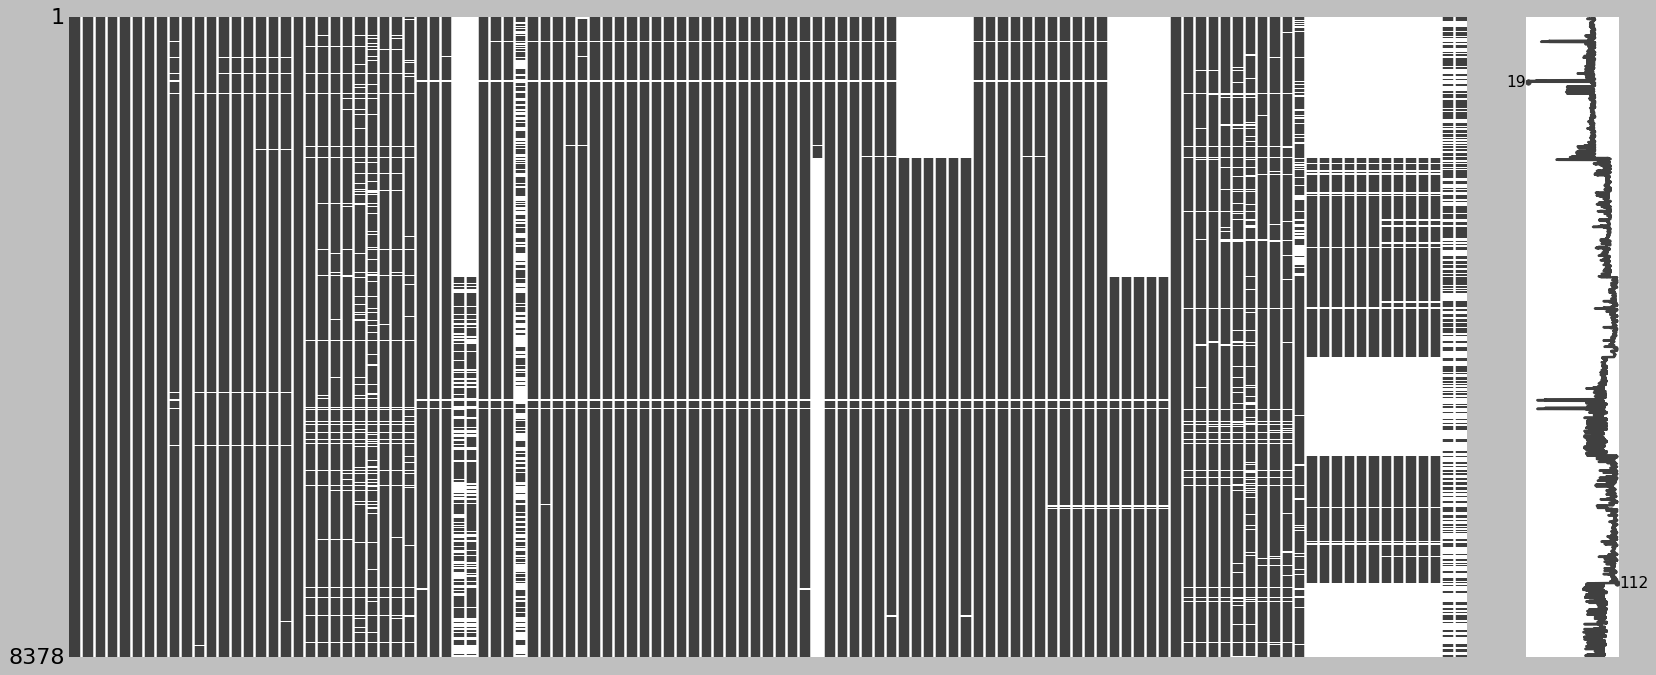

In [81]:
# Check missing values with a matrix visualization 
msno.matrix(df)
plt.show()

In [82]:
def remove_columns_with_too_much_nans(df : pd.DataFrame , threshold_num : float , threshold_cat : float):
    '''Remove columns with too much nan's , with a arbitrary threshold both for categorical and numerical variables'''

    print('Before removing columns with too much missing values : ' , len(df.columns))
    for col in df:
        if df[col].dtype in [np.int64 , np.float64]:
            if 1 - len(df[col].dropna()) / len(df) >= threshold_num: # For the numerical columns I will derive them with Iterative Imputer
                df = df.drop(col , axis=1)
        else:
            if 1 - len(df[col].dropna()) / len(df) >= threshold_cat: # For the categorical values , a threshold of 30 per cent seems acceptable for replacing by the mode
                df = df.drop(col , axis=1) 
    print('After removing columns with too much missing values : ' , len(df.columns))

    return df


df = remove_columns_with_too_much_nans(df , 0.5 , 0.3)

Before removing columns with too much missing values :  113
After removing columns with too much missing values :  96


#### Before going any futher , let's deal with missing values

In [83]:
if 1 + 1 == 3: # To save time
    num_col = df.select_dtypes(include=np.number).columns 
    cat_col = df.select_dtypes(include=object).columns 

    # Derive the numerical missing values , replace categorical by the mode
    imputer_num = IterativeImputer(estimator=XGBRegressor() , max_iter=10)
    imputer_cat = SimpleImputer(strategy='most_frequent')

    # Transform the columns directly in the dataset
    df[num_col] = imputer_num.fit_transform(df[num_col])
    df[cat_col] = imputer_cat.fit_transform(df[cat_col])

    df.to_csv('clean_df.csv')

else:
    df = pd.read_csv('clean_df.csv' , index_col='Unnamed: 0')

#### Let's explore the ages , overall and by gender

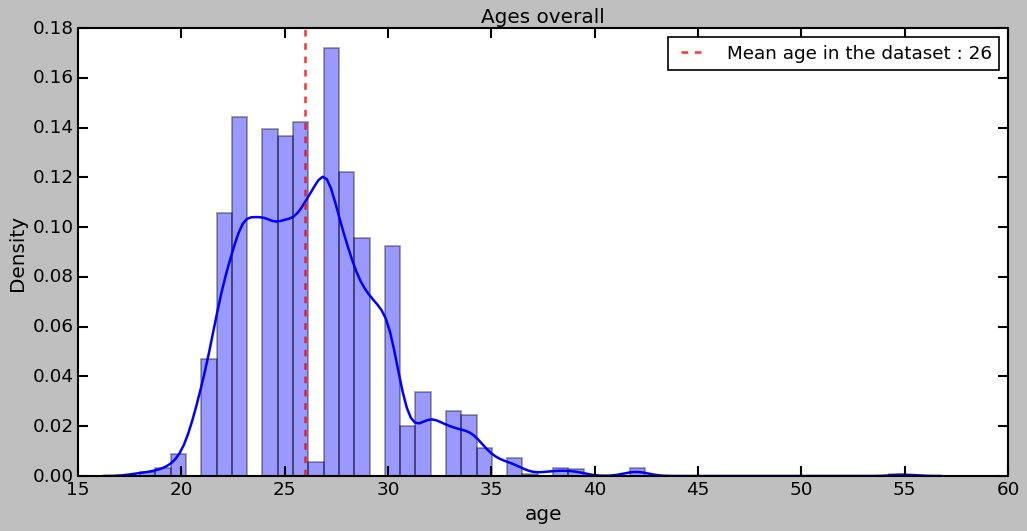

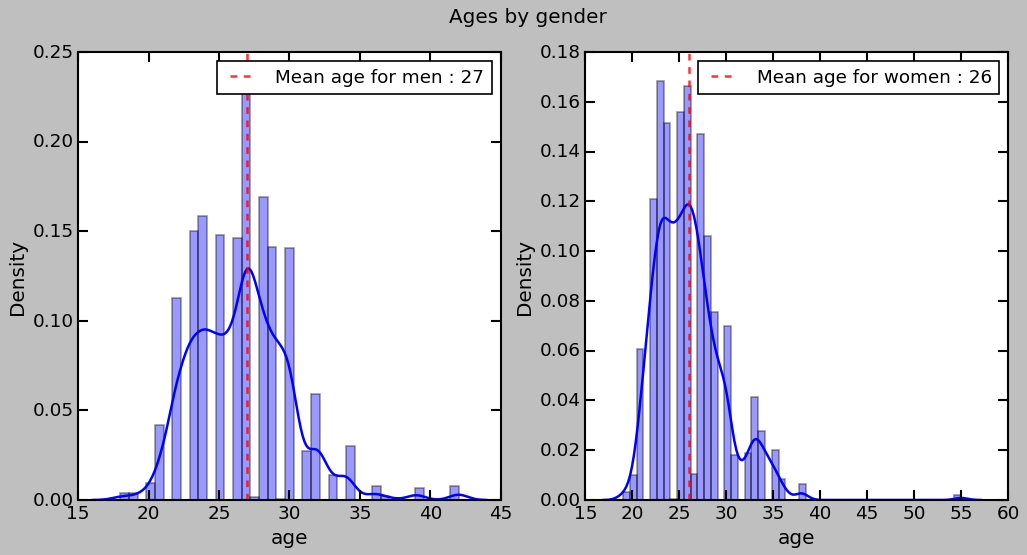

In [84]:
# Style matters
plt.style.use('classic')
sns.set_context('talk')

# Plot overall
mean_age = round(df['age'].mean())
plt.figure(figsize=(15,7))
sns.distplot(df['age'])
plt.axvline(mean_age , linestyle='--' , color='red' , alpha=0.8 , label=f'Mean age in the dataset : {mean_age}')
plt.legend()
plt.title('Ages overall')
plt.show()

# Subset for man and women
df_men = df[df['gender'] == 1]
df_women = df[df['gender'] == 0]

# Ages by gender
mean_age_man = round(df_men['age'].mean())
mean_age_woman = round(df_women['age'].mean())

# Plot by gender
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
sns.distplot(df_men['age'], ax=ax1)
sns.distplot(df_women['age'] , ax=ax2)
ax1.axvline(mean_age_man , linestyle='--' , color='red' , alpha=0.8 , label=f'Mean age for men : {mean_age_man}')
ax2.axvline(mean_age_woman , linestyle='--' , color='red' , alpha=0.8 , label=f'Mean age for women : {mean_age_woman}')
ax1.legend()
ax2.legend()
fig.suptitle('Ages by gender')
plt.show()

In [85]:
# Are men really older than women in this experience ?
p_value = ttest_ind(df_men['age'] , df_women['age'])[1]
alpha = 0.05

if p_value <= alpha:
    print('There is a statistical significant difference in the ages between mean and women.')
else:
    print('There is no statistical significant difference in the ages between mean and women.')

There is a statistical significant difference in the ages between mean and women.


From this figure we can see that there is no marked trend except for the fact that older men (from age 35) tend to receive less extreme results (little to very good or very bad rating) compared to younger men. Let's see if the trend holds true the other way around.

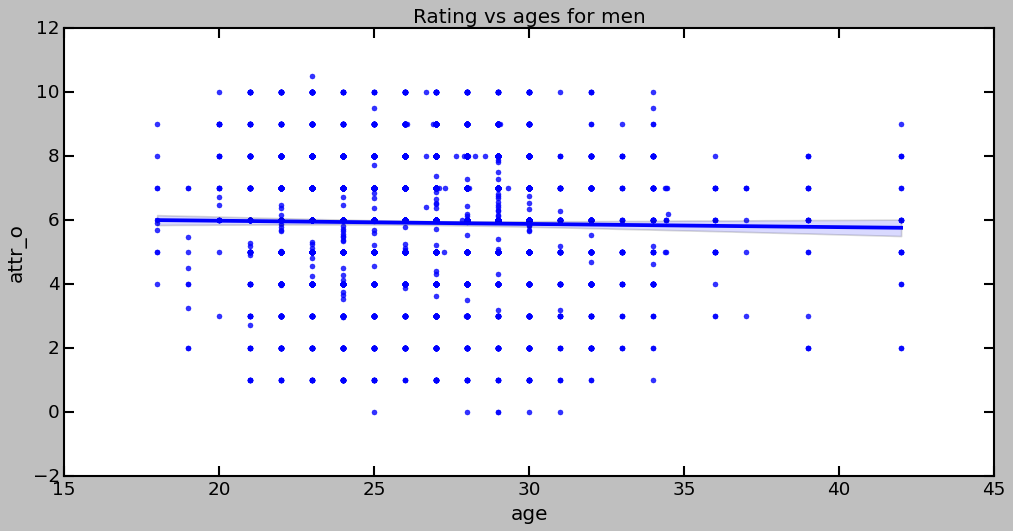

In [86]:
# How does rating from women evolve with age ?
plt.figure(figsize=(15,7))
sns.regplot(x=df_men['age'] , y=df_men['attr_o'])
plt.title('Rating vs ages for men')
plt.show()

The same trend appears for the men rating women. Also , we can see that there is some outliers in the women dataset , with some 55 years old women.

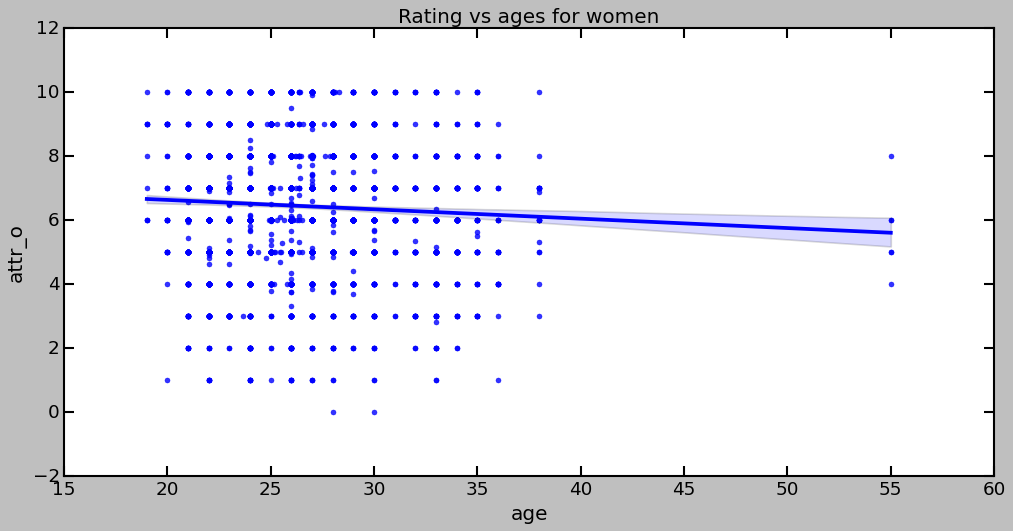

In [87]:
# How does rating from men evolve with age ?
plt.figure(figsize=(15,7))
sns.regplot(x=df_women['age'] , y=df_women['attr_o'])
plt.title('Rating vs ages for women')
plt.show()

Let's explore the ratings , overall and by gender

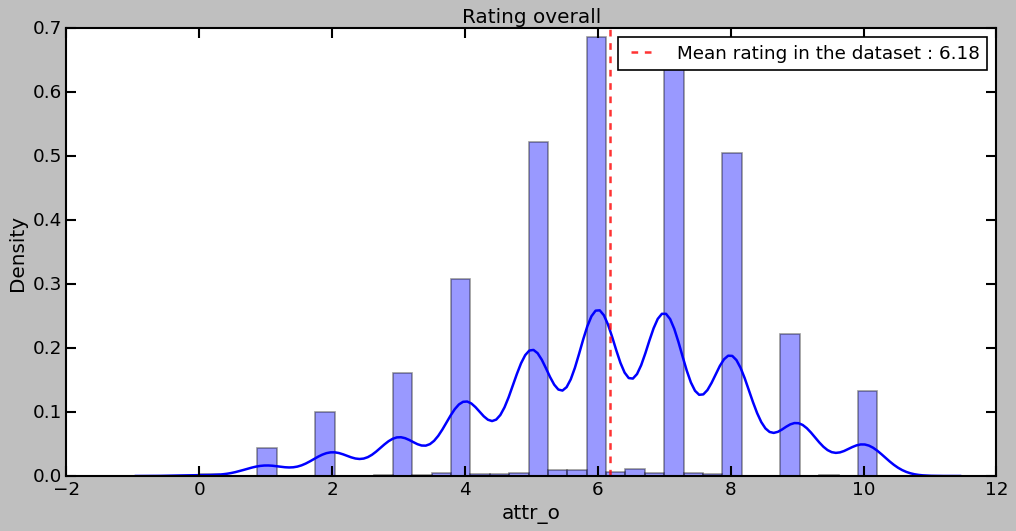

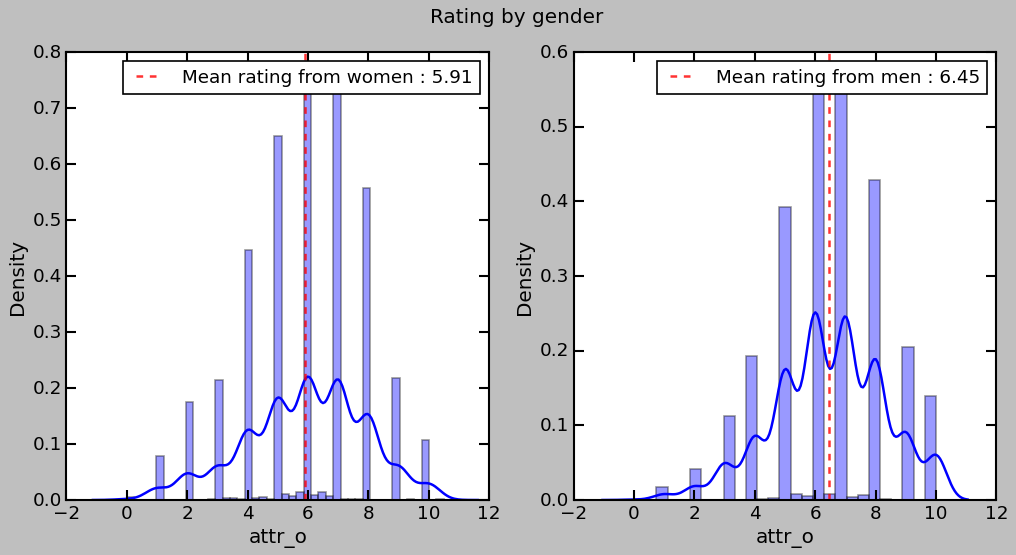

In [88]:
# Distribution of ratings by gender
mean_rating = round(df['attr_o'].mean() , 2)
plt.figure(figsize=(15,7))
sns.distplot(df['attr_o'])
plt.axvline(mean_rating , linestyle='--' , color='red' , alpha=0.8 , label=f'Mean rating in the dataset : {mean_rating}')
plt.legend()
plt.title('Rating overall')
plt.show()

# Ages by gender
mean_attr_o_man = round(df_men['attr_o'].mean() , 2)
mean_attr_o_woman = round(df_women['attr_o'].mean() , 2)

fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(15,7))
sns.distplot(df_men['attr_o'], ax=ax1)
sns.distplot(df_women['attr_o'] , ax=ax2)
ax1.axvline(mean_attr_o_man , linestyle='--' , color='red' , alpha=0.8 , label=f'Mean rating from women : {mean_attr_o_man}')
ax2.axvline(mean_attr_o_woman , linestyle='--' , color='red' , alpha=0.8 , label=f'Mean rating from men : {mean_attr_o_woman}')
ax1.legend()
ax2.legend()
fig.suptitle('Rating by gender')
plt.show()

In [89]:
# Do the two gender give different ratings in average ?
p_value = ttest_ind(df_men['attr_o'] , df_women['attr_o'])[1]
alpha = 0.05

if p_value <= alpha:
    print('There is a statistical significant difference in the overall ratings between mean and women.')
else:
    print('There is no statistical significant difference in the overall ratings between mean and women.')

There is a statistical significant difference in the overall ratings between mean and women.


Do people with the same race get along more ?

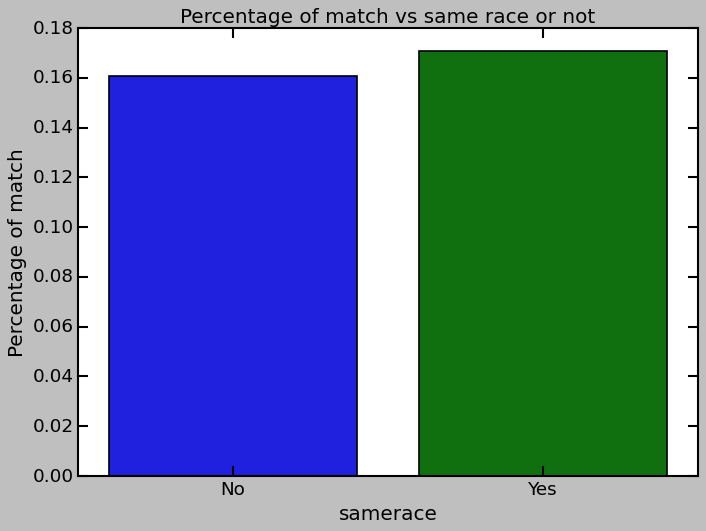

In [90]:
grp = df.groupby('samerace' , as_index=False)['match'].value_counts(normalize=True)
grp = grp[grp['match'] == 1.0].drop('match' , axis=1)

plt.figure(figsize=(10,7))
sns.barplot(data=grp , x='samerace' , y='proportion' , edgecolor='black')
plt.title('Percentage of match vs same race or not')
plt.xticks([0.0 , 1.0] , ['No' , 'Yes'])
plt.ylabel('Percentage of match')
plt.show()

In [91]:
print(df.groupby('samerace')['match'].value_counts() , '\n')

match = np.array([814 , 566]) # N success
nobs_ = np.array([4248 + 814 , 2750 + 566]) # Total by groups
z_score , p_val = proportions_ztest(count=match, nobs=nobs_)

if p_val <= alpha:
    print('There is a statistically significant difference in the proportion of matches between people who date someone of their race and those who do not.')
else:
    print('There is no evidence of a statistically significant difference in the proportion of matches between people who date someone of their race and those who do not.')

samerace  match
0.0       0.0      4248
          1.0       814
1.0       0.0      2750
          1.0       566
Name: match, dtype: int64 

There is no evidence of a statistically significant difference in the proportion of matches between people who date someone of their race and those who do not.


#### What do people want in a partner ? For men and women.
In this figure we can see that the most important characteristic for men is 'Attractive', while for women it is 'intelligent'. We can also notice that women distribute their expectations more evenly, while men give more importance to certain characteristics than to others. Indeed, the average standard deviation in the distribution of points in men is more than twice as high as in women.

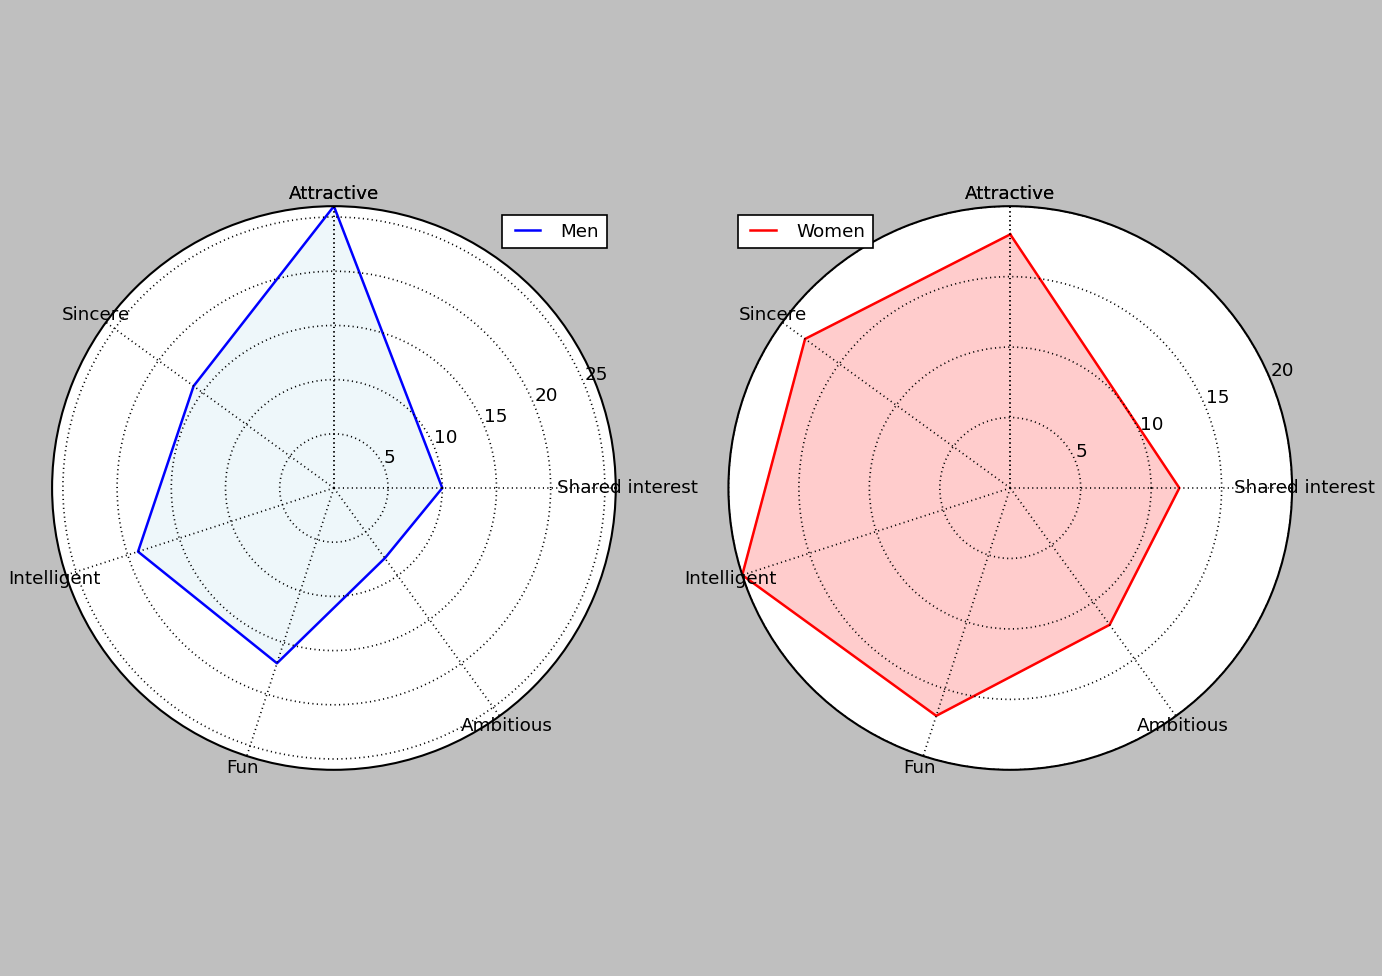

In [92]:
# Thetagrid
labels0 = ['Attractive' , 'Sincere', 'Intelligent' , 'Fun', 'Ambitious' , 'Shared interest' , 'Attractive']
label_pos = np.linspace(start=np.pi / 2, stop=2 * np.pi, num=6, endpoint=True)
label_pos = np.concatenate((label_pos, [label_pos[0]]))

val_men = list(df_men[['attr1_1' , 'sinc1_1' , 'intel1_1' , 'fun1_1' , 'amb1_1' , 'shar1_1']].mean().apply(lambda x : int(x)).values)
val_women = list(df_women[['attr1_1' , 'sinc1_1' , 'intel1_1' , 'fun1_1' , 'amb1_1' , 'shar1_1']].mean().apply(lambda x : int(x)).values)
val_men.append(val_men[0])
val_women.append(val_women[0])


fig, ax = plt.subplots(1,2, figsize=(20,15))
gs = GridSpec(1, 2)
ax[0].axis('off')
ax[0]= fig.add_subplot(gs[0,0], projection='polar')
ax[0].plot(label_pos, val_men, label='Men', color='blue')
ax[0].fill(label_pos, val_men, color='lightblue', alpha = 0.2)
lines, labels = plt.thetagrids(np.degrees(label_pos), labels=labels0)
plt.legend(loc='upper right')

ax[1].axis('off')
ax[1]= fig.add_subplot(gs[0,1], projection='polar')
ax[1].plot(label_pos, val_women, label='Women', color='red')
ax[1].fill(label_pos, val_women, color='red', alpha = 0.2)
lines, labels = plt.thetagrids(np.degrees(label_pos), labels=labels0)
plt.legend(loc='upper left')
plt.show()

#print(np.std(df_men[['attr1_1' , 'sinc1_1' , 'intel1_1' , 'fun1_1' , 'amb1_1' , 'shar1_1']].mean().values))
#print(np.std(df_women[['attr1_1' , 'sinc1_1' , 'intel1_1' , 'fun1_1' , 'amb1_1' , 'shar1_1']].mean().values))

#### How important do people think attractiveness is in potential mate selection vs. its real impact ?

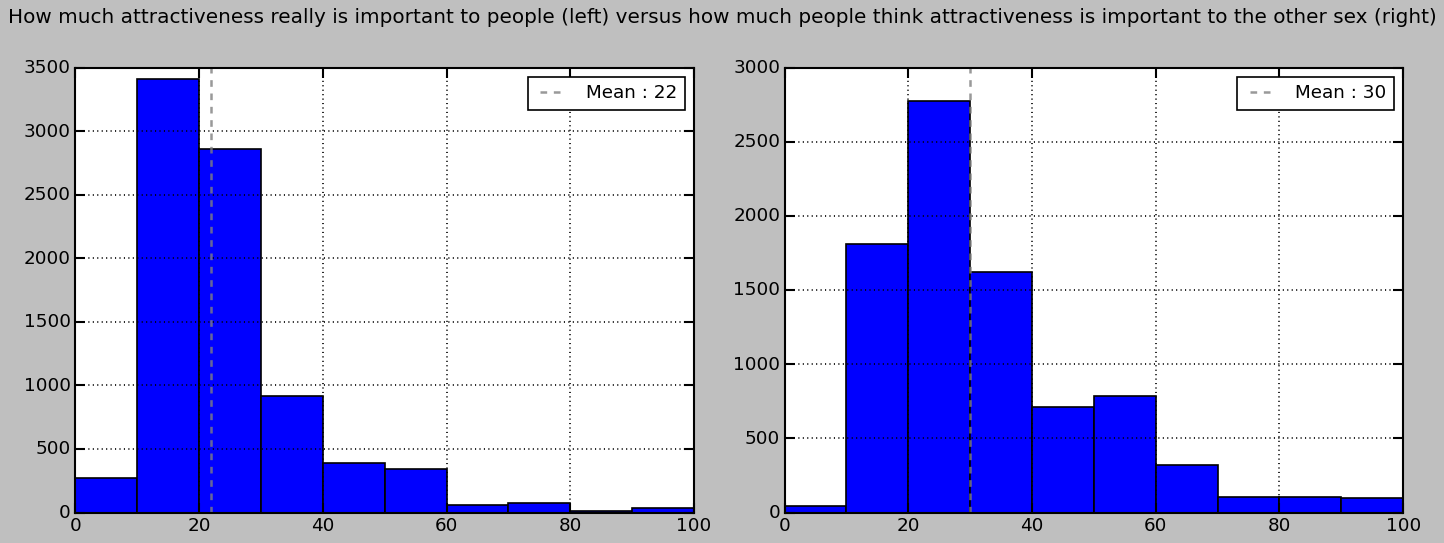

In [93]:
fig , (ax1 , ax2) = plt.subplots(1 , 2 , figsize=(18,7))

mean_attr1 = round(df['attr1_1'].mean())
mean_attr2 = round(df['attr2_1'].mean())

df['attr1_1'].hist(ax=ax1)
df['attr2_1'].hist(ax=ax2)

ax1.axvline(mean_attr1 , alpha=0.8 , color='grey' , linestyle='--' , label=f'Mean : {mean_attr1}')
ax2.axvline(mean_attr2 , alpha=0.8 , color='grey' , linestyle='--' , label=f'Mean : {mean_attr2}')

ax1.legend()
ax2.legend()

fig.suptitle('How much attractiveness really is important to people (left) versus how much people think attractiveness is important to the other sex (right)')
plt.tight_layout()

In [94]:
statistic, p_value = mannwhitneyu(df['attr1_1'], df['attr2_1'], alternative='two-sided')
if p_value <= alpha:
    print('There is a statistically significative difference between what people think is the importance of being attractive for the other sex , and the real importance that people give to that characteristic.')
else: 
    print('There is no statistically significative evidence difference between what people think is the importance of being attractive for the other sex , and the real importance that people give to that characteristic.')

There is a statistically significative difference between what people think is the importance of being attractive for the other sex , and the real importance that people give to that characteristic.


In [95]:
# Since the data description is not very clear , I make the hypothesis that the variables which finishs by _o all have the same meeting (rating by partner the night of event). I will make inference based on that
to_keep = ['int_corr' , 'samerace' , 'fun_o' , 'shar_o' , 'intel_o' , 'amb_o' , 'age_o' , 'match']
inference_df = df[to_keep]

#### Correlation hunting

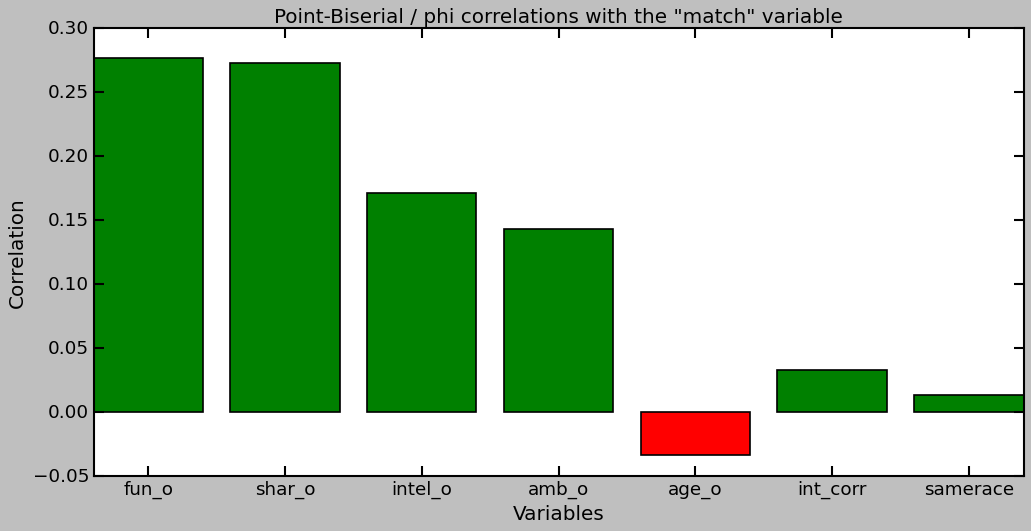

In [96]:
def check_correlation(target : str , df : pd.DataFrame , method : str):
    """Returns a sorted dataframe with the columns names and their correlation with 
    the specified target variable"""
   
    cor = [df[target].corr(df[col] , method=method) for col in df.columns]
    dictio = dict(zip(df.columns , cor))

    to_ret = pd.DataFrame({'columns' : dictio.keys()  , 'correlation_with_the_specified_target' : dictio.values()})\
    .sort_values(by=['correlation_with_the_specified_target'] , ascending=False)[1:]

    to_ret['abs_correlation'] = abs(to_ret['correlation_with_the_specified_target']) 


    return to_ret.sort_values(by='abs_correlation' , ascending=False).drop('abs_correlation' , axis=1)

corr_ = check_correlation(target ='match' , df=inference_df , method='pearson')

colors = ['green' if corr >= 0 else 'red' for corr in corr_['correlation_with_the_specified_target']]

plt.figure(figsize=(15,7))
plt.bar(x=corr_['columns'] , height=corr_['correlation_with_the_specified_target'] , color=colors , edgecolor='black')
plt.title('Point-Biserial / phi correlations with the "match" variable')
plt.xlabel('Variables')
plt.ylabel('Correlation')
plt.show()